In [1]:
pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled p

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(



=== Inference: V1 ===


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Confusion Matrix (actual [REAL, FAKE] vs predicted [REAL, FAKE]):
[[48  2]
 [50  0]]


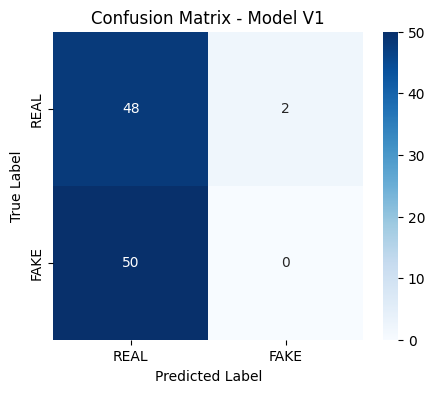


===============V1===============
Recall Real Videos    : 0.9600
Macro F1              : 0.3243
Average Precision     : 0.5000
ROC-AUC               : 0.4800
IOU                   : 0.0000
Latency               : 0.1855

=== Inference: V2 ===


100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Confusion Matrix (actual [REAL, FAKE] vs predicted [REAL, FAKE]):
[[44  6]
 [45  5]]


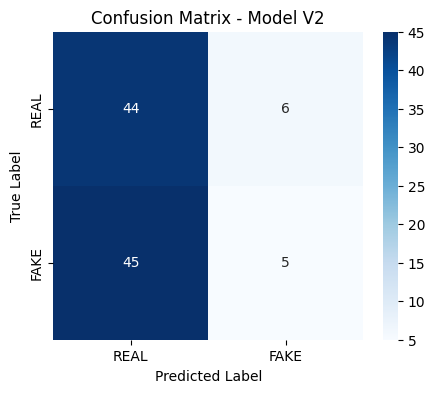


===============V2===============
Recall Real Videos    : 0.8800
Macro F1              : 0.3985
Average Precision     : 0.4955
ROC-AUC               : 0.4900
IOU                   : 0.0893
Latency               : 0.2054

=== Inference: V3 ===


100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Confusion Matrix (actual [REAL, FAKE] vs predicted [REAL, FAKE]):
[[47  3]
 [47  3]]


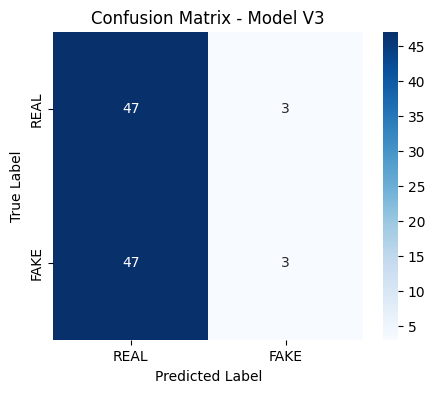


===============V3===============
Recall Real Videos    : 0.9400
Macro F1              : 0.3800
Average Precision     : 0.5000
ROC-AUC               : 0.5000
IOU                   : 0.0566
Latency               : 0.1819

=== Inference: V4 ===


100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


Confusion Matrix (actual [REAL, FAKE] vs predicted [REAL, FAKE]):
[[40 10]
 [15 35]]


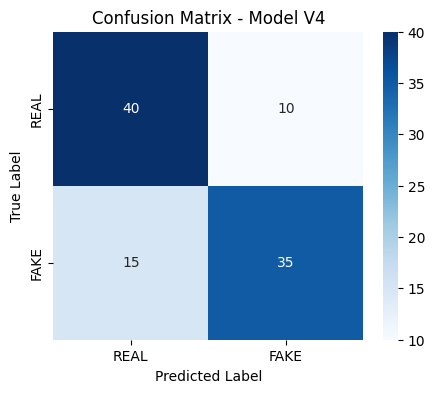


===============V4===============
Recall Real Videos    : 0.8000
Macro F1              : 0.7494
Average Precision     : 0.6944
ROC-AUC               : 0.7500
IOU                   : 0.5833
Latency               : 0.1988

=== Inference: V5 ===


100%|██████████| 100/100 [00:30<00:00,  3.24it/s]

Confusion Matrix (actual [REAL, FAKE] vs predicted [REAL, FAKE]):
[[ 4 46]
 [ 0 50]]


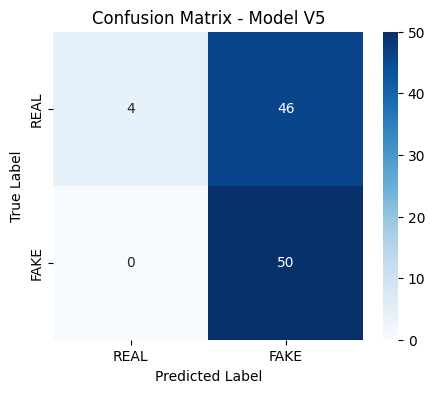


===============V5===============
Recall Real Videos    : 0.0800
Macro F1              : 0.4165
Average Precision     : 0.5208
ROC-AUC               : 0.5400
IOU                   : 0.5208
Latency               : 0.3072

=== METRIC TABLE ===
Model      Recall Real Videos         Macro F1 Average Precision          ROC-AUC              IOU          Latency
v1                   0.9600           0.3243           0.5000           0.4800           0.0000           0.1855
v2                   0.8800           0.3985           0.4955           0.4900           0.0893           0.2054
v3                   0.9400           0.3800           0.5000           0.5000           0.0566           0.1819
v4                   0.8000           0.7494           0.6944           0.7500           0.5833           0.1988
v5                   0.0800           0.4165           0.5208           0.5400           0.5208           0.3072


In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import time
from tqdm import tqdm

# --- Metrics
from sklearn.metrics import recall_score, f1_score, average_precision_score, roc_auc_score, confusion_matrix

import tensorflow as tf
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns

# ==== PATH SETTING ====
VIDEO_DIR = "/content/drive/MyDrive/Penelitian/testing-data-indo/videos/"
CSV_PATH = "/content/test-inference.csv"

FRAME_COUNT = 8
RESIDUE_COUNT = 7
FRAME_SHAPE = (64, 144)

# ==== Load Data ====
df = pd.read_csv(CSV_PATH)
video_paths = [os.path.join(VIDEO_DIR, x) for x in df['video']]
y_true = [1 if l.lower() == "fake" else 0 for l in df['label']]  # 1=fake, 0=real

# ===== PIPELINE =====
class MouthExtractor:
    MOUTH_LANDMARKS = [61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308]
    def __init__(self):
        self.mp_face_mesh = mp.solutions.face_mesh
        self.face_mesh = self.mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)
    def crop(self, img):
        result = self.face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if not result.multi_face_landmarks:
            return cv2.resize(img, (144, 64))
        h, w, _ = img.shape
        pts = np.array([[int(lm.x*w), int(lm.y*h)] for lm in result.multi_face_landmarks[0].landmark])
        try:
            mouth_pts = pts[self.MOUTH_LANDMARKS]
        except:
            return cv2.resize(img, (144, 64))
        x, y, w_m, h_m = cv2.boundingRect(mouth_pts)
        pad_w, pad_h = int(w_m*0.2), int(h_m*0.5)
        x1, y1 = max(0, x-pad_w), max(0, y-pad_h)
        x2, y2 = min(w, x+w_m+pad_w), min(h, y+h_m+pad_h)
        crop = img[y1:y2, x1:x2]
        crop_resize = cv2.resize(crop, (144, 64))
        return crop_resize

def load_video_frames(video_path, frame_count=FRAME_COUNT, dim=FRAME_SHAPE, mouth_crop=False):
    cap = cv2.VideoCapture(video_path)
    frames = []
    mouth_extractor = MouthExtractor() if mouth_crop else None
    try:
        while len(frames) < frame_count:
            ret, frame = cap.read()
            if not ret:
                break
            if mouth_extractor is not None:
                crop = mouth_extractor.crop(frame)
            else:
                crop = cv2.resize(frame, (dim[1], dim[0]))
            frames.append(crop)
    finally:
        cap.release()
    frames = np.array(frames)
    if len(frames) == 0:
        return np.zeros((frame_count, dim[0], dim[1], 3), dtype=np.float32)
    if len(frames) < frame_count:
        padding = np.zeros((frame_count - len(frames), dim[0], dim[1], 3), dtype=np.float32)
        frames = np.concatenate([frames, padding], axis=0)
    return frames.astype(np.float32) / 255.0

def compute_residue(frames):
    residues = np.zeros((RESIDUE_COUNT, 64, 144, 3), dtype=np.float32)
    for i in range(1, len(frames)):
        residues[i-1] = frames[i] - frames[i-1]
    return residues

def load_custom_model(weight_path, custom=True):
    # Custom model for v2/v4/v5
    from tensorflow.keras.layers import Input, Lambda, Dense
    from tensorflow.keras.models import Model

    class MultiHeadAttention(tf.keras.layers.Layer):
        def __init__(self, num_heads, key_dim, **kwargs):
            super().__init__(**kwargs)
            self.num_heads = num_heads
            self.key_dim = key_dim
            self.d_model = num_heads * key_dim
            self.query_dense = tf.keras.layers.Dense(self.d_model)
            self.key_dense = tf.keras.layers.Dense(self.d_model)
            self.value_dense = tf.keras.layers.Dense(self.d_model)
            self.combine_heads = tf.keras.layers.Dense(self.d_model)
        def split_heads(self, x, batch_size):
            x = tf.reshape(x, (batch_size, -1, self.num_heads, self.key_dim))
            return tf.transpose(x, perm=[0, 2, 1, 3])
        def call(self, query, value, key):
            batch_size = tf.shape(query)[0]
            query = self.query_dense(query)
            key = self.key_dense(key)
            value = self.value_dense(value)
            query = self.split_heads(query, batch_size)
            key = self.split_heads(key, batch_size)
            value = self.split_heads(value, batch_size)
            matmul_qk = tf.matmul(query, key, transpose_b=True)
            dk = tf.cast(tf.shape(key)[-1], tf.float32)
            scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
            attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
            output = tf.matmul(attention_weights, value)
            output = tf.transpose(output, perm=[0, 2, 1, 3])
            output = tf.reshape(output, (batch_size, -1, self.d_model))
            return self.combine_heads(output)
        def get_config(self):
            config = super().get_config()
            config.update({"num_heads": self.num_heads, "key_dim": self.key_dim})
            return config

    class VisionTemporalTransformer(tf.keras.layers.Layer):
        def __init__(self, patch_size=8, d_model=128, num_heads=4, spatial_layers=1, temporal_layers=1, **kwargs):
            super().__init__(**kwargs)
            self.patch_size = patch_size
            self.d_model = d_model
            self.num_heads = num_heads
            self.spatial_layers = spatial_layers
            self.temporal_layers = temporal_layers
            self.dense_projection = tf.keras.layers.Dense(d_model)
            self.spatial_mhas = [MultiHeadAttention(num_heads, d_model//num_heads) for _ in range(spatial_layers)]
            self.spatial_norm1 = [tf.keras.layers.LayerNormalization() for _ in range(spatial_layers)]
            self.spatial_ffn = [tf.keras.Sequential([
                tf.keras.layers.Dense(d_model*4, activation='relu'),
                tf.keras.layers.Dense(d_model)
            ]) for _ in range(spatial_layers)]
            self.spatial_norm2 = [tf.keras.layers.LayerNormalization() for _ in range(spatial_layers)]
            self.temporal_mhas = [MultiHeadAttention(num_heads, d_model//num_heads) for _ in range(temporal_layers)]
            self.temporal_norm1 = [tf.keras.layers.LayerNormalization() for _ in range(temporal_layers)]
            self.temporal_ffn = [tf.keras.Sequential([
                tf.keras.layers.Dense(d_model*4, activation='relu'),
                tf.keras.layers.Dense(d_model)
            ]) for _ in range(temporal_layers)]
            self.temporal_norm2 = [tf.keras.layers.LayerNormalization() for _ in range(temporal_layers)]
        def build(self, input_shape):
            H = input_shape[2]
            W = input_shape[3]
            ph = H // self.patch_size
            pw = W // self.patch_size
            num_patches = ph * pw
            self.pos_emb = self.add_weight(shape=(1, num_patches, self.d_model), initializer='random_normal', trainable=True, name='pos_emb')
            super().build(input_shape)
        def call(self, inputs):
            input_shape = inputs.get_shape()
            shape = tf.shape(inputs)
            batch = shape[0]
            frames = shape[1]
            H = shape[2]
            W = shape[3]
            C_static = input_shape[-1]
            C = C_static if C_static is not None else shape[4]
            reshaped = tf.reshape(inputs, (-1, H, W, C))
            patches = tf.image.extract_patches(
                images=reshaped,
                sizes=[1, self.patch_size, self.patch_size, 1],
                strides=[1, self.patch_size, self.patch_size, 1],
                rates=[1,1,1,1],
                padding='VALID'
            )
            patch_dim_static = self.patch_size * self.patch_size * (C_static or 3)
            patches = tf.reshape(patches, (-1, tf.shape(patches)[1] * tf.shape(patches)[2], patch_dim_static))
            x = self.dense_projection(patches) + self.pos_emb
            for i in range(self.spatial_layers):
                attn = self.spatial_mhas[i](x, value=x, key=x)
                x = self.spatial_norm1[i](x + attn)
                ff = self.spatial_ffn[i](x)
                x = self.spatial_norm2[i](x + ff)
            x = tf.reshape(x, (batch, frames, -1, self.d_model))
            x = tf.reduce_mean(x, axis=2)
            x.set_shape([None, None, self.d_model])
            for i in range(self.temporal_layers):
                attn = self.temporal_mhas[i](x, value=x, key=x)
                x = self.temporal_norm1[i](x + attn)
                ff = self.temporal_ffn[i](x)
                x = self.temporal_norm2[i](x + ff)
            pooled = tf.keras.layers.GlobalAveragePooling1D()(x)
            return pooled
        def get_config(self):
            config = super().get_config()
            config.update({
                "patch_size": self.patch_size,
                "d_model": self.d_model,
                "num_heads": self.num_heads,
                "spatial_layers": self.spatial_layers,
                "temporal_layers": self.temporal_layers,
            })
            return config

    frame_input = Input(shape=(FRAME_COUNT,64,144,3), name='FrameInput')
    residue_input = Input(shape=(RESIDUE_COUNT,64,144,3), name='ResidueInput')
    vt = VisionTemporalTransformer(patch_size=8, d_model=128, num_heads=4, spatial_layers=1, temporal_layers=1)
    frame_feat = vt(frame_input)
    residue_feat = vt(residue_input)
    expand1 = Lambda(lambda x: tf.expand_dims(x, axis=1))
    q = expand1(frame_feat)
    k = expand1(residue_feat)
    v = k
    mha = MultiHeadAttention(num_heads=4, key_dim=32)
    attn_out = mha(q, value=v, key=k)
    squeeze = Lambda(lambda x: tf.squeeze(x, axis=1))
    attn_out = squeeze(attn_out)
    concat = Lambda(lambda t: tf.concat(t, axis=1))
    fusion = concat([frame_feat, residue_feat, attn_out])
    x = Dense(512, activation='relu')(fusion)
    x = Dense(256, activation='relu')(x)
    class_output = Dense(2, activation='softmax', name='class_output')(x)
    features_output = Dense(128, activation=None, name='features_output')(x)
    model = Model(inputs=[frame_input, residue_input], outputs=[class_output, features_output], name='LIPINC_fixed')
    model.load_weights(weight_path)
    return model

def load_kerasmodel(weight_path):
    from tensorflow.keras.layers import Input, Lambda, Dense, Layer, GlobalAveragePooling1D, LayerNormalization
    from tensorflow.keras.models import Model

    class VisionTemporalTransformer(Layer):
        def __init__(self, patch_size=8, d_model=128, num_heads=4, spatial_layers=1, temporal_layers=1, **kwargs):
            super(VisionTemporalTransformer, self).__init__(**kwargs)
            self.patch_size = patch_size
            self.d_model = d_model
            self.num_heads = num_heads
            self.spatial_layers = spatial_layers
            self.temporal_layers = temporal_layers
            self.dense_projection = Dense(d_model)
            self.pos_emb = None
            self.spatial_mhas = [tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads) for _ in range(spatial_layers)]
            self.spatial_norm1 = [LayerNormalization() for _ in range(spatial_layers)]
            self.spatial_ffn = [tf.keras.Sequential([Dense(d_model*4, activation='relu'), Dense(d_model)]) for _ in range(spatial_layers)]
            self.spatial_norm2 = [LayerNormalization() for _ in range(spatial_layers)]
            self.temporal_mhas = [tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads) for _ in range(temporal_layers)]
            self.temporal_norm1 = [LayerNormalization() for _ in range(temporal_layers)]
            self.temporal_ffn = [tf.keras.Sequential([Dense(d_model*4, activation='relu'), Dense(d_model)]) for _ in range(temporal_layers)]
            self.temporal_norm2 = [LayerNormalization() for _ in range(temporal_layers)]
        def build(self, input_shape):
            _, frames, H, W, C = input_shape
            ph = H // self.patch_size
            pw = W // self.patch_size
            num_patches = ph * pw
            self.pos_emb = self.add_weight(shape=(1, num_patches, self.d_model), initializer='random_normal', trainable=True, name='pos_emb')
            super(VisionTemporalTransformer, self).build(input_shape)
        def call(self, inputs):
            batch = tf.shape(inputs)[0]
            frames = tf.shape(inputs)[1]
            H = tf.shape(inputs)[2]
            W = tf.shape(inputs)[3]
            C = tf.shape(inputs)[4]
            reshaped = tf.reshape(inputs, (-1, H, W, C))
            patches = tf.image.extract_patches(
                images=reshaped,
                sizes=[1, self.patch_size, self.patch_size, 1],
                strides=[1, self.patch_size, self.patch_size, 1],
                rates=[1,1,1,1],
                padding='VALID'
            )
            num_patches = tf.shape(patches)[1] * tf.shape(patches)[2]
            patch_dim = tf.shape(patches)[-1]
            patches = tf.reshape(patches, (-1, num_patches, patch_dim))
            x = self.dense_projection(patches) + self.pos_emb
            for i in range(self.spatial_layers):
                attn = self.spatial_mhas[i](query=x, value=x, key=x)
                x = self.spatial_norm1[i](x + attn)
                ff = self.spatial_ffn[i](x)
                x = self.spatial_norm2[i](x + ff)
            d_model = tf.shape(x)[-1]
            x = tf.reshape(x, (batch, frames, -1, d_model))
            x = tf.reduce_mean(x, axis=2)
            for i in range(self.temporal_layers):
                attn = self.temporal_mhas[i](query=x, value=x, key=x)
                x = self.temporal_norm1[i](x + attn)
                ff = self.temporal_ffn[i](x)
                x = self.temporal_norm2[i](x + ff)
            pooled = GlobalAveragePooling1D()(x)
            return pooled
        def get_config(self):
            config = super().get_config()
            config.update({
                "patch_size": self.patch_size,
                "d_model": self.d_model,
                "num_heads": self.num_heads,
                "spatial_layers": self.spatial_layers,
                "temporal_layers": self.temporal_layers,
            })
            return config

    frame_input = Input(shape=(FRAME_COUNT,64,144,3), name='FrameInput')
    residue_input = Input(shape=(RESIDUE_COUNT,64,144,3), name='ResidueInput')
    vt = VisionTemporalTransformer(patch_size=8, d_model=128, num_heads=4, spatial_layers=1, temporal_layers=1)
    frame_feat = vt(frame_input)
    residue_feat = vt(residue_input)
    expand1 = Lambda(lambda x: tf.expand_dims(x, axis=1))
    q = expand1(frame_feat)
    k = expand1(residue_feat)
    v = k
    mha = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=32)
    attn_out = mha(query=q, value=v, key=k)
    squeeze = Lambda(lambda x: tf.squeeze(x, axis=1))
    attn_out = squeeze(attn_out)
    concat = Lambda(lambda t: tf.concat(t, axis=1))
    fusion = concat([frame_feat, residue_feat, attn_out])
    x = Dense(512, activation='relu')(fusion)
    x = Dense(256, activation='relu')(x)
    class_output = Dense(2, activation='softmax', name='class_output')(x)
    features_output = Dense(128, activation=None, name='features_output')(x)
    model = Model(inputs=[frame_input, residue_input], outputs=[class_output, features_output], name='LIPINC_fixed')
    model.load_weights(weight_path)
    return model

model_paths = {
    "v1": "/content/v1.h5",
    "v2": "/content/v2.h5",
    "v3": "/content/v3.h5",
    "v4": "/content/v4.h5",
    "v5": "/content/v5.h5"
}
models = {
    "v1": load_kerasmodel(model_paths["v1"]),
    "v2": load_custom_model(model_paths["v2"]),
    "v3": load_custom_model(model_paths["v3"]),
    "v4": load_custom_model(model_paths["v4"]),
    "v5": load_custom_model(model_paths["v5"])
}

METRIC_NAMES = [
    "Recall Real Videos",
    "Macro F1",
    "Average Precision",
    "ROC-AUC",
    "IOU",
    "Latency"
]
results = {}

for key, model in models.items():
    print(f"\n=== Inference: {key.upper()} ===")
    y_probs, y_preds, times = [], [], []

    for path, label in tqdm(zip(video_paths, y_true), total=len(y_true)):
        mouth_crop = (key == "v5")  # v5 saja yang pakai crop mouth
        start = time.time()
        frames = load_video_frames(path, mouth_crop=mouth_crop)
        residues = compute_residue(frames)
        X_frames = np.expand_dims(frames, axis=0)
        X_residues = np.expand_dims(residues, axis=0)
        pred, _ = model.predict([X_frames, X_residues], verbose=0)
        prob_fake = float(pred[0][1])
        pred_label = 1 if prob_fake > 0.5 else 0
        y_probs.append(prob_fake)
        y_preds.append(pred_label)
        times.append(time.time() - start)

    cm = confusion_matrix(y_true, y_preds, labels=[0, 1])
    print("Confusion Matrix (actual [REAL, FAKE] vs predicted [REAL, FAKE]):")
    print(cm)

    # PLOT Confusion Matrix sebagai gambar!
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["REAL", "FAKE"], yticklabels=["REAL", "FAKE"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Model {key.upper()}")
    plt.show()

    recall_real = recall_score(y_true, y_preds, pos_label=0)
    macro_f1 = f1_score(y_true, y_preds, average='macro')
    avg_prec = average_precision_score(y_true, y_probs)
    try:
        roc_auc = roc_auc_score(y_true, y_probs)
    except Exception:
        roc_auc = 0.0
    iou_fake = cm[1,1] / (cm[1,1] + cm[1,0] + cm[0,1] + 1e-7) if cm.shape == (2,2) else 0.0
    avg_latency = np.mean(times)
    results[key] = [recall_real, macro_f1, avg_prec, roc_auc, iou_fake, avg_latency]

    print(f"\n{key.upper():=^32}")
    for n, v in zip(METRIC_NAMES, results[key]):
        print(f"{n:<22}: {v:.4f}")

print("\n=== METRIC TABLE ===")
print(f"{'Model':<10} " + " ".join([f"{m:>16}" for m in METRIC_NAMES]))
for key, metrics in results.items():
    print(f"{key:<10} " + " ".join([f"{m:16.4f}" for m in metrics]))